## 1. 变分自编码器 variational autoencoder (VAE)

[VAE论文](https://arxiv.org/pdf/1312.6114)

这里有篇很好的文章：[From Autoencoder to Beta-VAE](https://lilianweng.github.io/posts/2018-08-12-vae/)

In [5]:
from IPython.display import Image, display
url = 'https://lilianweng.github.io/posts/2018-08-12-vae/autoencoder-architecture.png'
display(Image(url=url, width=600))

In [6]:
url = 'https://lilianweng.github.io/posts/2018-08-12-vae/VAE-graphical-model.png'
display(Image(url=url, width=600))

In [7]:
url = 'https://lilianweng.github.io/posts/2018-08-12-vae/vae-gaussian.png'
display(Image(url=url, width=600))

第一张图：autoencoder可以看作是矩阵分解，类比SVD  
第二张图：概率图模型框架下VAE，观测由隐变量z生成  
第三张图：VAE的一些细节。可以用很多词对去描述这个过程，比如编码-解码；降维-升维；压缩-还原；推入-拉回。从观测到潜在分布，称之为学习；从潜在分布生成数据，称之为推断。  

---

## 2. 数学表达式

模型假定数据$x$由某个潜变量$z$生成

潜变量$z$具有某个先验分布$p(z)$，一般假定为标准正态分布. $z\sim N(0,I)$

模型的联合概率分布为 $p_\theta(x,z)=p_\theta(x|z)p(z)$

目标是最大化$x$的边缘似然 $$p_\theta(x)=\int p_\theta(x|z)p(z)dz$$

因为积分计算困难，引入变分推断。

---

引入变分分布$q_\phi(z|x)$迫近真实后验分布$p_\theta(z|x)$

为衡量迫近程度，需要度量两个分布之间的距离，使其最小化。采用KL散度，根据定义
$$D_{KL}(q_\phi(z|x)||p_\theta(z|x)) = \mathbb{E}_{q_\phi(z|x)}\left[log\frac{q_\phi(z|x)}{p_\theta(z|x)}\right] $$

注：实际上，我们定义了一个的参数分布族$\{p_\theta\}_{\theta\in\Theta}$

然后寻找最优分布以最小化某个损失函数$L(\theta)$，这是一类泛函极值问题，来源于最速降线问题。

变分推断另一个常见的场景是混合高斯模型（Gaussian Mixture Model，GMM）

---

**琴生不等式**  
如果f(x)是凸函数  
在二元情况下有：$\frac{f(x_1)+f(x_2)}{2}\geqslant f(\frac{x_1+x_2}{2})$  

在n元情况下有：$\frac{f(x_1)+f(x_2)+\cdots+f(x_n)}{n}\geqslant f(\frac{x_1+x_2+\cdots+x_n}{n})$ 

由于琴生不等式在加权的情况下也成立，即
$\frac{\alpha_1f(x_1)+\alpha_2f(x_2)+\cdots+\alpha_nf(x_n)}{\alpha_1+\alpha_1+\cdots+\alpha_n}\geqslant f(\frac{\alpha_1x_1+\alpha_2x_2+\cdots+\alpha_nx_n}{\alpha_1+\alpha_1+\cdots+\alpha_n})$  

不等式左边是函数值的期望，右边是期望的函数值，即 $\mathbb{E}[f(x)]\geqslant f(\mathbb{E}(x))$  

在f(x)是凹函数的情况下，有对应的不等式。log(x)是凹函数，于是 $\mathbb{E}[log(x)]\leqslant log(\mathbb{E}(x))$

---

目标的对数边缘似然：
$$\log p_\theta(x)=\log \int p_\theta(x,z)dz=\log \int \frac{p_\theta(x,z)}{q_\phi(z|x)} q_\phi(z|x)dz$$


$$\geqslant \int \log \frac{p_\theta(x,z)}{q_\phi(z|x)} q_\phi(z|x)dz
=\mathbb{E}_{q_\phi(z|x)}\log \frac{p_\theta(x,z)}{q_\phi(z|x)}
=\mathbb{E}_{q_\phi(z|x)}\log \frac{p_\theta(x|z) p(z)}{q_\phi(z|x)}$$

$$=\mathbb{E}_{q_\phi(z|x)}\log p_\theta(x|z)-D_{KL}(q_\phi(z|x)||p(z))$$

不等式右边的结果称为证据下界（evidence lower bound, ELBO），又称变分下界或负变分自由能。  
ELBO由两项构成，第一项称为重构项，衡量解码器从潜在变量z重构数据x的能力，类似于自编码器的重建损失（如交叉熵或均方误差）；第二项是正则项，约束近似后验接近先验，防止过拟合。  
下界的意思是至少是这么多，因此为了最大化目标函数，就需要最大化ELBO，等价与最小化ELBO的负值（优化理论约定），于是有
$$\arg \mathop{\min}_{\theta,\phi}D_{KL}(q_\phi(z|x)||p(z))-\mathbb{E}_{q_\phi(z|x)}\log p_\theta(x|z)$$


---

编码器建模：$q_\phi(z|x)$  

通常假定为对角高斯分布。$q_\phi(z|x)=\mathcal{N}(z;\mu_\phi(x),\sigma_\phi^2(x))$ 

解码器建模：$p_\theta(x|z)$  

根据数据类型选择分布：二值数据（如黑白的MNIST）用伯努利分布；连续数据（如CIFAR-10, 256个值）用高斯分布。

为了收敛性，使用重参数化技巧（[Reparameterization Trick](https://gregorygundersen.com/blog/2018/04/29/reparameterization/)），采样$z\sim q_\phi(z|x)$，于是  

$z=\mu_\phi(x)+\sigma_\phi(x)\odot\epsilon, \epsilon \sim \mathcal{N}(0, I) $


In [9]:
url = 'https://gregorygundersen.com/image/reparam/vae.png'
display(Image(url=url, width=600))

因为$q_\phi(z|x)$是对角高斯分布，$p(z)$是标准正态分布，则$D_{KL}(q_\phi(z|x)||p(z))$项有闭式解。  
$$D_{KL}(\mathcal{N}(\mu_\phi(x),\sigma^2_\phi(x)I)||\mathcal{N}(0,I))
=\frac{1}{2}\sum_{i=1}^d(\mu_i^2+\sigma^2_i-1-ln\sigma^2_i)$$

第二项，通过蒙特卡洛方法计算，但一般只取一个样本！

---

后续优化：
（1）$\beta$-VAE：引入超参数$\beta$，强化正则项。$\mathcal{L}(\theta, \phi)=-\mathbb{E}_{q_\phi(z|x)}\log p_\theta(x|z)+\beta\cdot D_{KL}(q_\phi(z|x)||p(z))$     

论文[$\beta$-VAE](https://www.cs.toronto.edu/~bonner/courses/2022s/csc2547/papers/generative/disentangled-representations/beta-vae,-higgins,-iclr2017.pdf)

（2）CVAE：引入条件变量$y$，建模$p_\theta(x|z,y)$  

论文[CVAE](https://arxiv.org/pdf/1812.04405)

（3）VQVAE：使用向量量化（Vector Quantization）改进潜在表示。

论文[VQVAE](https://arxiv.org/pdf/1711.00937)

## 3. 简单实现

In [1]:
import os
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, Subset
from torch.amp import autocast, GradScaler
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchinfo import summary

import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [2]:
# 超参数
image_size = 256
downscale = 4
batch_size = 64
latent_dim = 32
in_channels = 3
out_channels = 3
epochs = 100
learning_rate = 1e-4
save_path = 'model_pkl/vae.pth'
data_path = 'data/celeba_hq_256/'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).view(1, 3, 1, 1).to(tensor.device)
    std = torch.tensor(std).view(1, 3, 1, 1).to(tensor.device)
    return tensor * std + mean

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [4]:
# CelebA-HQ Super-Resolution Dataset
class CelebASuperRes(torch.utils.data.Dataset):
    def __init__(self, root, transform=None, size=256, downscale=4):
        self.root = root
        self.transform = transform
        self.size = size
        self.downscale = downscale
        self.images = [f for f in os.listdir(root) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.root, self.images[idx])).convert('RGB')
        hr = transforms.Resize((self.size, self.size))(img)
        lr = transforms.Resize((self.size // self.downscale, self.size // self.downscale))(hr)
        lr = transforms.Resize((self.size, self.size), interpolation=Image.BICUBIC)(lr)
        if self.transform:
            hr = self.transform(hr)
            lr = self.transform(lr)
        return hr, lr

In [5]:
dataset = CelebASuperRes(data_path, transform=transform, size=image_size, downscale=downscale)
subset_dataset = Subset(dataset, range(5000))
dataloader = DataLoader(subset_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
unloader = transforms.ToPILImage()

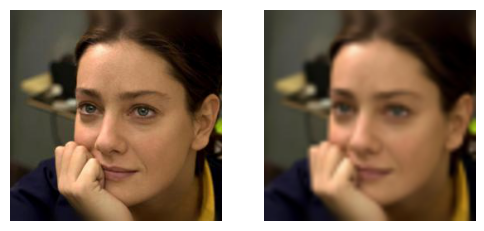

In [6]:
for x, y in dataloader:
    img1, img2 = x[0], y[0]
    img1 = denormalize(img1, mean, std)[0]
    img2 = denormalize(img2, mean, std)[0]
    img1 = unloader(img1)
    img2 = unloader(img2)
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    axes[0].imshow(img1)
    axes[0].axis('off')
    axes[1].imshow(img2)
    axes[1].axis('off')
    plt.show()
    break

In [7]:
class ResBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, 3, 1, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, 3, 1, 1)
        )

    def forward(self, x):
        return x + self.block(x)

In [8]:
class VAE(nn.Module):
    def __init__(self, in_channels=in_channels, latent_dim=latent_dim):
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            ResBlock(64),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            ResBlock(128),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            ResBlock(256),
            nn.Conv2d(256, latent_dim, kernel_size=3, stride=1, padding=1)
        )

        # Latent param maps
        self.conv_mu = nn.Conv2d(latent_dim, latent_dim, 1)
        self.conv_logvar = nn.Conv2d(latent_dim, latent_dim, 1)

        # Decoder
        self.decoder = nn.Sequential(
            ResBlock(latent_dim),
            nn.ConvTranspose2d(latent_dim, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            ResBlock(128),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            ResBlock(64),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, in_channels, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        enc = self.encoder(x)
        mu = self.conv_mu(enc)
        logvar = self.conv_logvar(enc)
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z)
        return recon, mu, logvar

In [9]:
def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    recon_loss = F.mse_loss(recon_x, x, reduction='mean')
    kl_div = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl_div, recon_loss, kl_div

In [10]:
# 初始化模型
model = VAE()
summary(model, input_size=(32, 3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [32, 3, 256, 256]         --
├─Sequential: 1-1                        [32, 32, 32, 32]          --
│    └─Conv2d: 2-1                       [32, 32, 256, 256]        896
│    └─ReLU: 2-2                         [32, 32, 256, 256]        --
│    └─Conv2d: 2-3                       [32, 64, 128, 128]        32,832
│    └─ReLU: 2-4                         [32, 64, 128, 128]        --
│    └─ResBlock: 2-5                     [32, 64, 128, 128]        --
│    │    └─Sequential: 3-1              [32, 64, 128, 128]        73,856
│    └─Conv2d: 2-6                       [32, 128, 64, 64]         131,200
│    └─ReLU: 2-7                         [32, 128, 64, 64]         --
│    └─ResBlock: 2-8                     [32, 128, 64, 64]         --
│    │    └─Sequential: 3-2              [32, 128, 64, 64]         295,168
│    └─Conv2d: 2-9                       [32, 256, 32, 32]        

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

In [12]:
def train_vae(model):
    model.to(device)
    scaler = GradScaler()

    for epoch in range(epochs):
        model.train()
        total_loss, total_recon, total_kl = 0.0, 0.0, 0.0

        # beta = min(1.0, epoch / 10.0)  # KL warmup

        best_loss = float('inf')
        pbar = tqdm.tqdm(dataloader, desc=f"Epoch {epoch+1}")

        for images, _ in pbar:
            images = images.to(device)
            optimizer.zero_grad()

            with autocast(device_type='cuda'):
                recon, mu, logvar = model(images)
                loss, recon_loss, kl_div = vae_loss(recon, images, mu, logvar)

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            total_recon += recon_loss.item()
            total_kl += kl_div.item()

        scheduler.step()
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | Recon: {total_recon:.4f} | KL: {total_kl:.4f}")

        # Save best model
        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(model.state_dict(), save_path)
            print("Best model saved.")

In [13]:
train_vae(model)

Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████| 79/79 [00:39<00:00,  1.99it/s]


Epoch 1/100 | Loss: 1.2648 | Recon: 97.2391 | KL: 2.6806
Best model saved.


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████| 79/79 [00:39<00:00,  2.00it/s]


Epoch 2/100 | Loss: 0.6055 | Recon: 45.1639 | KL: 2.6668
Best model saved.


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████| 79/79 [00:40<00:00,  1.94it/s]


Epoch 3/100 | Loss: 0.4570 | Recon: 33.0897 | KL: 3.0152
Best model saved.


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████| 79/79 [00:43<00:00,  1.84it/s]


Epoch 4/100 | Loss: 0.4261 | Recon: 30.5713 | KL: 3.0880
Best model saved.


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████| 79/79 [00:42<00:00,  1.88it/s]


Epoch 5/100 | Loss: 0.4141 | Recon: 29.5725 | KL: 3.1409
Best model saved.


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████████| 79/79 [00:43<00:00,  1.83it/s]


Epoch 6/100 | Loss: 0.4042 | Recon: 28.7318 | KL: 3.1977
Best model saved.


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████████| 79/79 [00:43<00:00,  1.80it/s]


Epoch 7/100 | Loss: 0.3985 | Recon: 28.2481 | KL: 3.2319
Best model saved.


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████████| 79/79 [00:44<00:00,  1.78it/s]


Epoch 8/100 | Loss: 0.3932 | Recon: 27.8282 | KL: 3.2349
Best model saved.


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████████| 79/79 [00:44<00:00,  1.76it/s]


Epoch 9/100 | Loss: 0.3889 | Recon: 27.5243 | KL: 3.2023
Best model saved.


Epoch 10: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:44<00:00,  1.76it/s]


Epoch 10/100 | Loss: 0.3855 | Recon: 27.2613 | KL: 3.1933
Best model saved.


Epoch 11: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:45<00:00,  1.75it/s]


Epoch 11/100 | Loss: 0.3794 | Recon: 26.7572 | KL: 3.2143
Best model saved.


Epoch 12: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:45<00:00,  1.75it/s]


Epoch 12/100 | Loss: 0.3753 | Recon: 26.4472 | KL: 3.2001
Best model saved.


Epoch 13: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:45<00:00,  1.73it/s]


Epoch 13/100 | Loss: 0.3736 | Recon: 26.3354 | KL: 3.1754
Best model saved.


Epoch 14: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:45<00:00,  1.73it/s]


Epoch 14/100 | Loss: 0.3709 | Recon: 26.1333 | KL: 3.1644
Best model saved.


Epoch 15: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:45<00:00,  1.73it/s]


Epoch 15/100 | Loss: 0.3696 | Recon: 26.0528 | KL: 3.1449
Best model saved.


Epoch 16: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:45<00:00,  1.72it/s]


Epoch 16/100 | Loss: 0.3679 | Recon: 25.9378 | KL: 3.1239
Best model saved.


Epoch 17: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:45<00:00,  1.73it/s]


Epoch 17/100 | Loss: 0.3667 | Recon: 25.8765 | KL: 3.0958
Best model saved.


Epoch 18: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:46<00:00,  1.70it/s]


Epoch 18/100 | Loss: 0.3643 | Recon: 25.6874 | KL: 3.0907
Best model saved.


Epoch 19: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:46<00:00,  1.70it/s]


Epoch 19/100 | Loss: 0.3618 | Recon: 25.5201 | KL: 3.0660
Best model saved.


Epoch 20: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:46<00:00,  1.70it/s]


Epoch 20/100 | Loss: 0.3597 | Recon: 25.3542 | KL: 3.0643
Best model saved.


Epoch 21: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:46<00:00,  1.71it/s]


Epoch 21/100 | Loss: 0.3568 | Recon: 25.1559 | KL: 3.0311
Best model saved.


Epoch 22: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:45<00:00,  1.72it/s]


Epoch 22/100 | Loss: 0.3542 | Recon: 24.9676 | KL: 3.0132
Best model saved.


Epoch 23: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:45<00:00,  1.72it/s]


Epoch 23/100 | Loss: 0.3526 | Recon: 24.8658 | KL: 2.9903
Best model saved.


Epoch 24: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:46<00:00,  1.72it/s]


Epoch 24/100 | Loss: 0.3517 | Recon: 24.7850 | KL: 2.9991
Best model saved.


Epoch 25: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:46<00:00,  1.71it/s]


Epoch 25/100 | Loss: 0.3502 | Recon: 24.6813 | KL: 2.9836
Best model saved.


Epoch 26: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:47<00:00,  1.66it/s]


Epoch 26/100 | Loss: 0.3472 | Recon: 24.4249 | KL: 3.0048
Best model saved.


Epoch 27: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:46<00:00,  1.69it/s]


Epoch 27/100 | Loss: 0.3470 | Recon: 24.4093 | KL: 3.0070
Best model saved.


Epoch 28: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:47<00:00,  1.66it/s]


Epoch 28/100 | Loss: 0.3450 | Recon: 24.2508 | KL: 3.0077
Best model saved.


Epoch 29: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:48<00:00,  1.63it/s]


Epoch 29/100 | Loss: 0.3443 | Recon: 24.1856 | KL: 3.0166
Best model saved.


Epoch 30: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:48<00:00,  1.63it/s]


Epoch 30/100 | Loss: 0.3437 | Recon: 24.1381 | KL: 3.0157
Best model saved.


Epoch 31: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:46<00:00,  1.69it/s]


Epoch 31/100 | Loss: 0.3428 | Recon: 24.0605 | KL: 3.0185
Best model saved.


Epoch 32: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:46<00:00,  1.69it/s]


Epoch 32/100 | Loss: 0.3420 | Recon: 24.0131 | KL: 3.0080
Best model saved.


Epoch 33: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:47<00:00,  1.66it/s]


Epoch 33/100 | Loss: 0.3420 | Recon: 24.0050 | KL: 3.0156
Best model saved.


Epoch 34: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:48<00:00,  1.64it/s]


Epoch 34/100 | Loss: 0.3413 | Recon: 23.9481 | KL: 3.0138
Best model saved.


Epoch 35: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:48<00:00,  1.64it/s]


Epoch 35/100 | Loss: 0.3410 | Recon: 23.9283 | KL: 3.0101
Best model saved.


Epoch 36: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:47<00:00,  1.66it/s]


Epoch 36/100 | Loss: 0.3429 | Recon: 24.0878 | KL: 2.9984
Best model saved.


Epoch 37: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:47<00:00,  1.67it/s]


Epoch 37/100 | Loss: 0.3407 | Recon: 23.9151 | KL: 2.9967
Best model saved.


Epoch 38: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:47<00:00,  1.65it/s]


Epoch 38/100 | Loss: 0.3406 | Recon: 23.9067 | KL: 3.0008
Best model saved.


Epoch 39: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:46<00:00,  1.69it/s]


Epoch 39/100 | Loss: 0.3398 | Recon: 23.8424 | KL: 2.9989
Best model saved.


Epoch 40: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:47<00:00,  1.67it/s]


Epoch 40/100 | Loss: 0.3385 | Recon: 23.7351 | KL: 3.0029
Best model saved.


Epoch 41: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:46<00:00,  1.71it/s]


Epoch 41/100 | Loss: 0.3393 | Recon: 23.8043 | KL: 3.0010
Best model saved.


Epoch 42: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:45<00:00,  1.72it/s]


Epoch 42/100 | Loss: 0.3399 | Recon: 23.8481 | KL: 3.0052
Best model saved.


Epoch 43: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:46<00:00,  1.71it/s]


Epoch 43/100 | Loss: 0.3387 | Recon: 23.7669 | KL: 2.9933
Best model saved.


Epoch 44: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:46<00:00,  1.71it/s]


Epoch 44/100 | Loss: 0.3383 | Recon: 23.7366 | KL: 2.9907
Best model saved.


Epoch 45: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:46<00:00,  1.71it/s]


Epoch 45/100 | Loss: 0.3389 | Recon: 23.7971 | KL: 2.9786
Best model saved.


Epoch 46: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:46<00:00,  1.70it/s]


Epoch 46/100 | Loss: 0.3374 | Recon: 23.6672 | KL: 2.9846
Best model saved.


Epoch 47: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:48<00:00,  1.63it/s]


Epoch 47/100 | Loss: 0.3374 | Recon: 23.6701 | KL: 2.9842
Best model saved.


Epoch 48: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:47<00:00,  1.65it/s]


Epoch 48/100 | Loss: 0.3365 | Recon: 23.6006 | KL: 2.9820
Best model saved.


Epoch 49: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:46<00:00,  1.69it/s]


Epoch 49/100 | Loss: 0.3362 | Recon: 23.5816 | KL: 2.9774
Best model saved.


Epoch 50: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:47<00:00,  1.65it/s]


Epoch 50/100 | Loss: 0.3364 | Recon: 23.5983 | KL: 2.9740
Best model saved.


Epoch 51: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:47<00:00,  1.66it/s]


Epoch 51/100 | Loss: 0.3391 | Recon: 23.8146 | KL: 2.9717
Best model saved.


Epoch 52: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:47<00:00,  1.65it/s]


Epoch 52/100 | Loss: 0.3363 | Recon: 23.5931 | KL: 2.9749
Best model saved.


Epoch 53: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:48<00:00,  1.64it/s]


Epoch 53/100 | Loss: 0.3367 | Recon: 23.6300 | KL: 2.9680
Best model saved.


Epoch 54: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:48<00:00,  1.64it/s]


Epoch 54/100 | Loss: 0.3373 | Recon: 23.6764 | KL: 2.9713
Best model saved.


Epoch 55: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:47<00:00,  1.65it/s]


Epoch 55/100 | Loss: 0.3358 | Recon: 23.5698 | KL: 2.9592
Best model saved.


Epoch 56: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:46<00:00,  1.70it/s]


Epoch 56/100 | Loss: 0.3359 | Recon: 23.5728 | KL: 2.9665
Best model saved.


Epoch 57: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:46<00:00,  1.70it/s]


Epoch 57/100 | Loss: 0.3359 | Recon: 23.5737 | KL: 2.9631
Best model saved.


Epoch 58: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:46<00:00,  1.70it/s]


Epoch 58/100 | Loss: 0.3358 | Recon: 23.5745 | KL: 2.9566
Best model saved.


Epoch 59: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:46<00:00,  1.70it/s]


Epoch 59/100 | Loss: 0.3354 | Recon: 23.5430 | KL: 2.9561
Best model saved.


Epoch 60: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:45<00:00,  1.72it/s]


Epoch 60/100 | Loss: 0.3358 | Recon: 23.5725 | KL: 2.9582
Best model saved.


Epoch 61: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:45<00:00,  1.72it/s]


Epoch 61/100 | Loss: 0.3357 | Recon: 23.5569 | KL: 2.9605
Best model saved.


Epoch 62: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:46<00:00,  1.71it/s]


Epoch 62/100 | Loss: 0.3358 | Recon: 23.5685 | KL: 2.9567
Best model saved.


Epoch 63: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:46<00:00,  1.72it/s]


Epoch 63/100 | Loss: 0.3349 | Recon: 23.5022 | KL: 2.9513
Best model saved.


Epoch 64: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:46<00:00,  1.71it/s]


Epoch 64/100 | Loss: 0.3356 | Recon: 23.5581 | KL: 2.9552
Best model saved.


Epoch 65: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:46<00:00,  1.72it/s]


Epoch 65/100 | Loss: 0.3376 | Recon: 23.7197 | KL: 2.9525
Best model saved.


Epoch 66: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:46<00:00,  1.71it/s]


Epoch 66/100 | Loss: 0.3345 | Recon: 23.4785 | KL: 2.9498
Best model saved.


Epoch 67: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:46<00:00,  1.71it/s]


Epoch 67/100 | Loss: 0.3350 | Recon: 23.5169 | KL: 2.9476
Best model saved.


Epoch 68: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:46<00:00,  1.72it/s]


Epoch 68/100 | Loss: 0.3356 | Recon: 23.5679 | KL: 2.9412
Best model saved.


Epoch 69: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:46<00:00,  1.71it/s]


Epoch 69/100 | Loss: 0.3347 | Recon: 23.4887 | KL: 2.9540
Best model saved.


Epoch 70: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:45<00:00,  1.72it/s]


Epoch 70/100 | Loss: 0.3341 | Recon: 23.4484 | KL: 2.9444
Best model saved.


Epoch 71: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:46<00:00,  1.71it/s]


Epoch 71/100 | Loss: 0.3342 | Recon: 23.4570 | KL: 2.9451
Best model saved.


Epoch 72: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:46<00:00,  1.71it/s]


Epoch 72/100 | Loss: 0.3338 | Recon: 23.4262 | KL: 2.9426
Best model saved.


Epoch 73: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:46<00:00,  1.71it/s]


Epoch 73/100 | Loss: 0.3344 | Recon: 23.4680 | KL: 2.9498
Best model saved.


Epoch 74: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:46<00:00,  1.69it/s]


Epoch 74/100 | Loss: 0.3366 | Recon: 23.6496 | KL: 2.9411
Best model saved.


Epoch 75: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:46<00:00,  1.71it/s]


Epoch 75/100 | Loss: 0.3335 | Recon: 23.4039 | KL: 2.9433
Best model saved.


Epoch 76: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:46<00:00,  1.72it/s]


Epoch 76/100 | Loss: 0.3347 | Recon: 23.5010 | KL: 2.9378
Best model saved.


Epoch 77: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:46<00:00,  1.72it/s]


Epoch 77/100 | Loss: 0.3347 | Recon: 23.5053 | KL: 2.9376
Best model saved.


Epoch 78: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:45<00:00,  1.72it/s]


Epoch 78/100 | Loss: 0.3343 | Recon: 23.4695 | KL: 2.9408
Best model saved.


Epoch 79: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:46<00:00,  1.71it/s]


Epoch 79/100 | Loss: 0.3340 | Recon: 23.4470 | KL: 2.9382
Best model saved.


Epoch 80: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:45<00:00,  1.72it/s]


Epoch 80/100 | Loss: 0.3346 | Recon: 23.4908 | KL: 2.9392
Best model saved.


Epoch 81: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:46<00:00,  1.71it/s]


Epoch 81/100 | Loss: 0.3348 | Recon: 23.5140 | KL: 2.9365
Best model saved.


Epoch 82: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:46<00:00,  1.71it/s]


Epoch 82/100 | Loss: 0.3348 | Recon: 23.5070 | KL: 2.9392
Best model saved.


Epoch 83: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:46<00:00,  1.71it/s]


Epoch 83/100 | Loss: 0.3338 | Recon: 23.4328 | KL: 2.9390
Best model saved.


Epoch 84: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:46<00:00,  1.71it/s]


Epoch 84/100 | Loss: 0.3340 | Recon: 23.4481 | KL: 2.9353
Best model saved.


Epoch 85: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:45<00:00,  1.72it/s]


Epoch 85/100 | Loss: 0.3341 | Recon: 23.4591 | KL: 2.9358
Best model saved.


Epoch 86: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:46<00:00,  1.71it/s]


Epoch 86/100 | Loss: 0.3336 | Recon: 23.4177 | KL: 2.9345
Best model saved.


Epoch 87: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:46<00:00,  1.71it/s]


Epoch 87/100 | Loss: 0.3342 | Recon: 23.4663 | KL: 2.9330
Best model saved.


Epoch 88: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:45<00:00,  1.72it/s]


Epoch 88/100 | Loss: 0.3342 | Recon: 23.4684 | KL: 2.9312
Best model saved.


Epoch 89: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:45<00:00,  1.72it/s]


Epoch 89/100 | Loss: 0.3330 | Recon: 23.3668 | KL: 2.9389
Best model saved.


Epoch 90: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:46<00:00,  1.70it/s]


Epoch 90/100 | Loss: 0.3346 | Recon: 23.4936 | KL: 2.9390
Best model saved.


Epoch 91: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:46<00:00,  1.72it/s]


Epoch 91/100 | Loss: 0.3340 | Recon: 23.4585 | KL: 2.9302
Best model saved.


Epoch 92: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:46<00:00,  1.69it/s]


Epoch 92/100 | Loss: 0.3334 | Recon: 23.4034 | KL: 2.9332
Best model saved.


Epoch 93: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:45<00:00,  1.72it/s]


Epoch 93/100 | Loss: 0.3332 | Recon: 23.3827 | KL: 2.9380
Best model saved.


Epoch 94: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:46<00:00,  1.72it/s]


Epoch 94/100 | Loss: 0.3341 | Recon: 23.4663 | KL: 2.9306
Best model saved.


Epoch 95: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:46<00:00,  1.71it/s]


Epoch 95/100 | Loss: 0.3344 | Recon: 23.4829 | KL: 2.9340
Best model saved.


Epoch 96: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:46<00:00,  1.71it/s]


Epoch 96/100 | Loss: 0.3335 | Recon: 23.4120 | KL: 2.9367
Best model saved.


Epoch 97: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:45<00:00,  1.72it/s]


Epoch 97/100 | Loss: 0.3341 | Recon: 23.4596 | KL: 2.9340
Best model saved.


Epoch 98: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:46<00:00,  1.72it/s]


Epoch 98/100 | Loss: 0.3333 | Recon: 23.3940 | KL: 2.9359
Best model saved.


Epoch 99: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:46<00:00,  1.71it/s]


Epoch 99/100 | Loss: 0.3353 | Recon: 23.5539 | KL: 2.9384
Best model saved.


Epoch 100: 100%|███████████████████████████████████████████████████████████████████████| 79/79 [00:46<00:00,  1.71it/s]

Epoch 100/100 | Loss: 0.3340 | Recon: 23.4580 | KL: 2.9308
Best model saved.


In [14]:
def load_vae(model, checkpoint_path, device='cuda'):
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.to(device)
    model.eval()
    return model

In [15]:
def plot_images(original_images, reconstructed_images, n_row=2, n_col=2):
    original_images = original_images.detach().cpu().numpy()
    reconstructed_images = reconstructed_images.detach().cpu().numpy()
    
    fig, axes = plt.subplots(n_row, n_col * 2, figsize=(8, 4))
    
    for i in range(n_row):
        for j in range(n_col):
            idx = i * n_col + j
            if idx >= original_images.shape[0]:
                continue
            axes[i, j * 2].imshow(np.transpose(original_images[idx], (1, 2, 0)))
            axes[i, j * 2].set_title("Original")
            axes[i, j * 2].axis('off')

            axes[i, j * 2 + 1].imshow(np.transpose(reconstructed_images[idx], (1, 2, 0)))
            axes[i, j * 2 + 1].set_title("Reconstructed")
            axes[i, j * 2 + 1].axis('off')
    
    plt.tight_layout()
    plt.show()

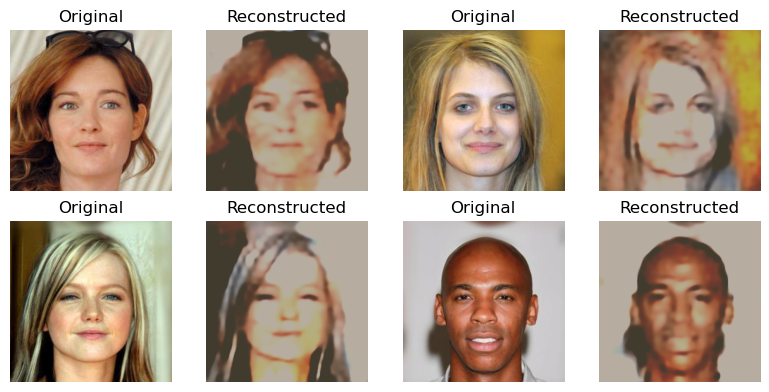

In [16]:
# 获取并展示重建的图像
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).view(1, 3, 1, 1).to(tensor.device)
    std = torch.tensor(std).view(1, 3, 1, 1).to(tensor.device)
    return tensor * std + mean

model.eval()
with torch.no_grad():
    sample_data, _ = next(iter(dataloader))
    sample_data = sample_data.to(device)
    original_images = sample_data
    original_images = denormalize(original_images, mean=mean, std=std)
    reconstructed_images = model(sample_data)[0]
    reconstructed_images = denormalize(reconstructed_images, mean=mean, std=std)
    plot_images(original_images, reconstructed_images)